In [1]:
import pandas as pd
xl = pd.ExcelFile("National Election India 1977 - 2014.xlsx")
xl.sheet_names
df = xl.parse("Sheet2")

In [2]:
# Cleaning data, misspellings
df = df.replace(['Chhattisgarh','Goa Daman & Diu', 'National Capital Territory Of Delhi', 'Nct Of Delhi','Orissa','Pondicherry','Uttaranchal'], ['Chattisgarh', 'Goa, Daman & Diu', 'Delhi', 'Delhi','Odisha','Puducherry','Uttarakhand'])
south_india=('Andhra Pradesh','Lakshadweep','Andaman & Nicobar Islands','Kerala','Karnataka', 'Pondicherry','Puducherry','Tamil Nadu')
north_india=('Rajasthan','Uttar Pradesh','Haryana','Punjab','Jammu & Kashmir','Delhi','Uttarakhand','Himachal Pradesh','Jharkhand', 'Dadra & Nagar Haveli','Chandigarh','Madhya Pradesh','Chattisgarh','Goa','Daman & Diu','Goa, Daman & Diu', 'Gujarat','Maharashtra','Bihar','Jharkhand','Odisha','Orissa','West Bengal','Arunachal Pradesh','Assam','Nagaland','Manipur', 'Mizoram','Meghalaya','Sikkim', 'Tripura')

# Assigning states to clusters
df['region']='default'
df['region'].loc[df['st_name'].isin(south_india)]= 'south_india'
df['region'].loc[df['st_name'].isin(north_india)]= 'north_india'
fdf = df.loc[df['cand_sex'] == 'F']

# calculate total votes by year
tot_voters = df.groupby('year')[['totvotpoll']].sum()
tot_voters = tot_voters.reset_index()

prev_yr = {}
for i, rw in tot_voters.iterrows():
    if i == 0:
        continue
    else:
        prev_yr[rw['year']] = tot_voters.loc[i - 1]['year']
prev_yr

tot_votes_fem = fdf.groupby(['year','region'])[['totvotpoll']].sum()
tot_votes_fem = tot_votes_fem.reset_index()

# calculate year on year growth based on the formula
overall_yoy = pd.DataFrame(columns=['year', 'region', 'growth'])

# loop with iterator as we need to access previous year and current year data
for i, rw in tot_voters.iterrows():
    if i == 0:
        # assign growth of 0 for 1st year
        overall_yoy = overall_yoy.append({'year': rw['year'], 'region': 'north_india', 'growth': 0}, ignore_index=True)
        overall_yoy = overall_yoy.append({'year': rw['year'], 'region': 'south_india', 'growth': 0}, ignore_index=True)
        continue
    else:
        # get current year data in a and b variables, previous year data in a1 and b1 variables
        a = tot_votes_fem.loc[tot_votes_fem['year'] == rw['year']]['totvotpoll'].iloc[0]
        b = tot_voters.loc[tot_voters['year'] == rw['year']]['totvotpoll'].iloc[0]
        a1 = tot_votes_fem.loc[tot_votes_fem['year'] == tot_voters.loc[i - 1]['year']]['totvotpoll'].iloc[0]
        b1 = tot_voters.loc[tot_voters['year'] == tot_voters.loc[i - 1]['year']]['totvotpoll'].iloc[0]
        overall_yoy = overall_yoy.append({'year': rw['year'], 'region': 'north_india', 'growth': ((a/b - a1/b1)/(a1/b1)) * 100}, ignore_index=True)
        overall_yoy = overall_yoy.append({'year': rw['year'], 'region': 'south_india', 'growth': ((a/b - a1/b1)/(a1/b1)) * 100}, ignore_index=True)

# combine growth with full dataset
df2 = pd.merge(df, overall_yoy, how='left', on=['year', 'region'])
tot_votes = df2.groupby(['year','region','cand_sex','growth'])[['totvotpoll']].sum()
tot_votes = tot_votes.reset_index()

# prepare dataframe for calculating region growth with vote counts
left_df1 = df.groupby(['year', 'region'])[['totvotpoll']].sum()
right_df1 = fdf.groupby(['year', 'region'])[['totvotpoll']].sum()
region_df = pd.merge(left_df1, right_df1, how='left', on=['year', 'region'])
region_df = region_df.fillna(0)

import numpy
region_yoy = pd.DataFrame(columns=['year', 'region', 'growth'])
for i, rw in region_df.iterrows():
    if rw.name[0] == 1977:
        region_yoy = region_yoy.append({'year': i[0], 'region': i[1], 'growth': 0}, ignore_index=True)
        continue
    else:
#         calculate year on year growth by comparing total and female votes
        a = rw['totvotpoll_y']
        b = rw['totvotpoll_x']
        a1 = region_df.loc[(prev_yr[i[0]], i[1])]['totvotpoll_y']
        b1 = region_df.loc[(prev_yr[i[0]], i[1])]['totvotpoll_x']
        region_yoy = region_yoy.append({'year': i[0], 'region': i[1], 'growth': ((a/b - a1/b1)/(a1/b1)) * 100}, ignore_index=True)
region_yoy.set_index(['year', 'region'])
region_yoy = region_yoy.reset_index()

# convert vote counts to millions
tot_votes['totvotpoll'] = tot_votes['totvotpoll']/1e6
tot_votes

E:\PYTHON\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,year,region,cand_sex,growth,totvotpoll
0,1977,north_india,F,0.000000,4.641996
1,1977,north_india,M,0.000000,130.290982
2,1977,south_india,F,0.000000,1.791680
3,1977,south_india,M,0.000000,52.192846
4,1980,north_india,F,64.225216,7.982740
5,1980,north_india,M,64.225216,135.066885
6,1980,south_india,F,64.225216,2.151766
7,1980,south_india,M,64.225216,52.622883
8,1984,north_india,F,16.877431,11.771153
9,1984,north_india,M,16.877431,168.810561


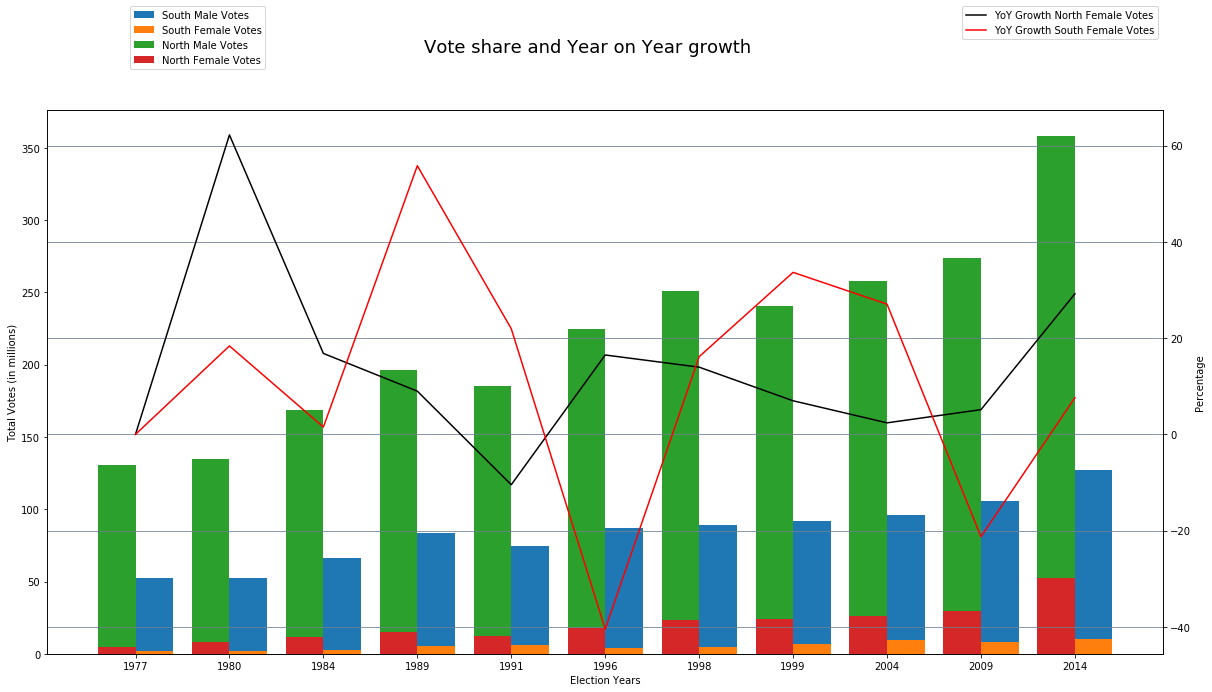

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot()
w = 0.4 # width of bars

# x axis year values
ind = list(tot_votes.year.unique())
ind = [str(x) for x in ind]

# find x axis values for male and female
ab_bar_list = [plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'M') & (tot_votes['region'] == 'south_india')].totvotpoll), align='edge', width= w, label='South Male Votes'),
               plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'F') & (tot_votes['region'] == 'south_india')].totvotpoll), align='edge', width= w, label='South Female Votes')]

cd_bar_list = [plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'M') & (tot_votes['region'] == 'north_india')].totvotpoll), align='edge',width= -w, label='North Male Votes'),
               plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'F') & (tot_votes['region'] == 'north_india')].totvotpoll), align='edge',width= -w, label='North Female Votes')]
# make another y axis for growth
ax_yoy = ax.twinx()
ax_yoy.grid(b=True, which='major', color='slategrey', linestyle='-')

# find corresponding growth y axis values for the same year
growth_north = list(region_yoy.loc[region_yoy['region'] == 'north_india'].growth)
growth_south = list(region_yoy.loc[region_yoy['region'] == 'south_india'].growth)
ax_yoy.plot(ind, growth_north, label='YoY Growth North Female Votes', color='black')
ax_yoy.plot(ind, growth_south, label='YoY Growth South Female Votes', color='r')
# ax_yoy.plot(ind, [0] * 11 , color='slategrey')

ax.legend(bbox_to_anchor=(0.2,1.2))
ax.set_xlabel('Election Years')
ax.set_ylabel('Total Votes (in millions)')
# ax_yoy.legend(loc='upper center')
ax_yoy.legend(bbox_to_anchor=(1,1.2))
ax_yoy.set_ylabel('Percentage')
plt.suptitle('Vote share and Year on Year growth', fontsize=18)
plt.savefig('yoy.png')

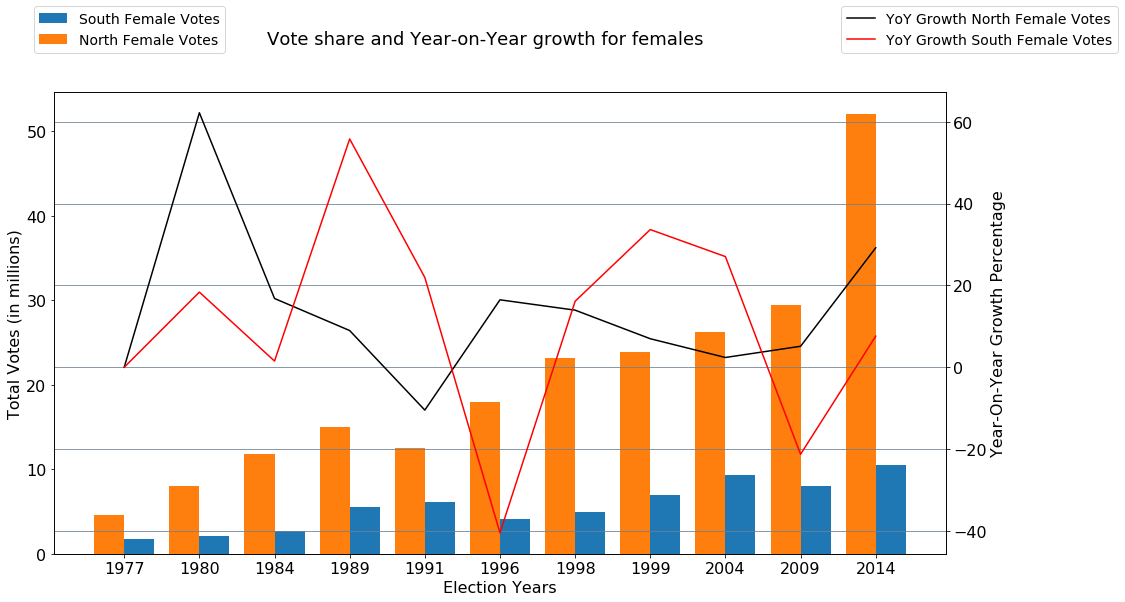

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16, 8.5))
ax = plt.subplot()
w = 0.4 # width of bars

# x axis year values
ind = list(tot_votes.year.unique())
ind = [str(x) for x in ind]

# find x axis values for male and female
ab_bar_list = [plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'F') & (tot_votes['region'] == 'south_india')].totvotpoll), align='edge', width= w, label='South Female Votes')]

cd_bar_list = [plt.bar(ind, list(tot_votes.loc[(tot_votes['cand_sex'] == 'F') & (tot_votes['region'] == 'north_india')].totvotpoll), align='edge',width= -w, label='North Female Votes')]

# make another y axis for growth
ax_yoy = ax.twinx()
ax_yoy.grid(b=True, which='major', color='slategrey', linestyle='-')

# find corresponding growth y axis values for the same year
growth_north = list(region_yoy.loc[region_yoy['region'] == 'north_india'].growth)
growth_south = list(region_yoy.loc[region_yoy['region'] == 'south_india'].growth)
ax_yoy.plot(ind, growth_north, label='YoY Growth North Female Votes', color='black')
ax_yoy.plot(ind, growth_south, label='YoY Growth South Female Votes', color='r')
# ax_yoy.plot(ind, [0] * 11 , color='slategrey')
ax_yoy.tick_params(labelsize=16)
ax.legend(bbox_to_anchor=(0.2,1.2), prop={'size': 14})
ax.set_xlabel('Election Years', fontsize=16)
ax.set_ylabel('Total Votes (in millions)', fontsize=16)
ax.tick_params(labelsize=16)
# ax_yoy.legend(loc='upper center')
ax_yoy.legend(bbox_to_anchor=(1.2,1.2), prop={'size': 14})
ax_yoy.set_ylabel('Year-On-Year Growth Percentage', fontsize=16)
plt.suptitle('Vote share and Year-on-Year growth for females', fontsize=18)
plt.rcParams.update({'font.size': 22})

plt.savefig('yoy.png')